In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from xgboost.sklearn import XGBClassifier

In [112]:
def visual(data, column_name):
    facet = sns.FacetGrid(data, hue='Survived', aspect=5)
    facet.map(sns.kdeplot, column_name, shade=True)
    facet.set(xlim=(0, data[column_name].max()))
    plt.xlim(0)
    plt.legend()

In [113]:
train_df = pd.read_csv('../data/titanic/train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [114]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### Visualization
Note that **Kernel Density Estimation (KDE)** is a way to estimate the probability density function of a continuous random variable.

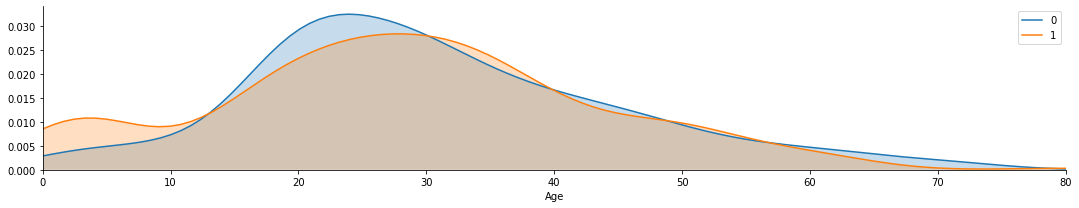

In [115]:
visual(train_df, column_name='Age')

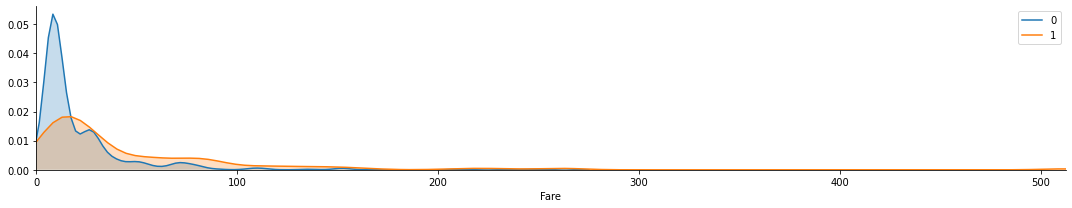

In [116]:
visual(train_df, column_name='Fare')

In [141]:
class Preprocess:
    def __init__(self):
        self.data = None
        self.sc = None

    def _cabin_to_cat(self):
        data = self.data
        data.Cabin.fillna(0, inplace=True)
        data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
        data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
        data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
        data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
        data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
        data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
        data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
        if any('T' in str(s) for s in data['Cabin']): 
            data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
        else:
            pass
        data['Cabin'] = data['Cabin'].astype('int64')
        self.data = data

    def _age_to_cat(self):
        data = self.data
        data.loc[data['Age'].isnull(), 'Age'] = data['Age'].mean()
        mean_age = data["Age"].mean()
        std_age = data["Age"].std()
        # data.loc[data['Age'].isnull(), 'Age'] = round(np.random.randint(mean_age - std_age, mean_age + std_age), 2)
        data['Age'] = data['Age'].astype('int64')
        data.loc[data['Age'] <= 10, 'Age'] = 0
        data.loc[(data['Age'] > 10) & (data['Age'] <= 30), 'Age'] = 1
        data.loc[(data['Age'] > 30) & (data['Age'] <= 60), 'Age'] = 2
        data.loc[data['Age'] > 60, 'Age'] = 3
        self.data = data

    def _sex_to_cat(self):
        data = self.data
        gender = {'male': 0, 'female': 1}
        data['Sex'] = data['Sex'].map(gender)
        self.data = data

    def _embarked_to_cat(self):
        data = self.data
        embarked = {'S': 0, 'C': 1, 'Q': 2}
        data.loc[data['Embarked'].isnull(), 'Embarked'] = 'S'
        data['Embarked'] = data['Embarked'].map(embarked)
        self.data = data

    def _fare_to_cat(self):
        data = self.data
        data.loc[data['Fare'].isnull(), 'Fare'] = 0
        data.loc[data['Fare'] <= 17, 'Fare'] = 0
        data.loc[(data['Fare'] > 17) & (data['Fare'] <= 30), 'Fare'] = 1
        data.loc[(data['Fare'] > 30) & (data['Fare'] <= 100), 'Fare'] = 2
        data.loc[data['Fare'] > 100, 'Fare'] = 3
        self.data = data

    def _name_to_cat(self):
        data = self.data
        data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
                                               'Sir', 'Jonkheer', 'Dona'], 'Rare')
        data['Title'] = data['Title'].replace('Mlle', 'Miss')
        data['Title'] = data['Title'].replace('Ms', 'Miss')
        data['Title'] = data['Title'].replace('Mme', 'Mrs')
        title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        data['Title'] = data['Title'].map(title_mapping)
        data['Title'] = data['Title'].fillna(0)
        data = data.drop(columns=['Name'], axis=1)
        self.data = data

    def _compute_loneliness(self):
        data = self.data
        data['Alone'] = data['SibSp'] + data['Parch']
        # data.loc[data['Alone'] > 0, 'Alone'] = 1
        # data.loc[data['Alone'] == 0, 'Alone'] = 0
        data = data.drop(columns=['SibSp', 'Parch'], axis=1)
        self.data = data

    def run(self, data):
        self.data = data.drop(columns=['Ticket'], axis=1)
        self._name_to_cat()
        self._age_to_cat()
        self._cabin_to_cat()
        self._sex_to_cat()
        self._embarked_to_cat()
        self._fare_to_cat()
        self._compute_loneliness()
        # print(self.data.info())

**LOAD DATA**

In [118]:
VERBOSE = True 
train_outputs = train_df['Survived']
pp = Preprocess()
pp.run(train_df.drop(columns=['Survived', 'PassengerId'], axis=1))
train_features = pp.data

if VERBOSE:
    pp.data.describe()
    pp.data.head()

**TRAIN**

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


In [145]:
xgb = XGBClassifier(max_depth=5, n_estimators=100)
xgb.fit(train_features, train_outputs)
scores = cross_val_score(xgb, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))

CrossVal: Mean: 0.83 , Standard Deviation: 0.04


In [150]:
xgb = AdaBoostClassifier(n_estimators=100, random_state=0)
xgb.fit(train_features, train_outputs)
scores = cross_val_score(xgb, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))

CrossVal: Mean: 0.81 , Standard Deviation: 0.02


In [120]:
svc = SVC(gamma='scale')
svc.fit(train_features, train_outputs)
scores = cross_val_score(svc, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))

CrossVal: Mean: 0.83 , Standard Deviation: 0.02


In [121]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
rf.fit(train_features, train_outputs)
scores = cross_val_score(rf, train_features, train_outputs, cv=k_fold, scoring="accuracy")
print("CrossVal:", "Mean:", round(scores.mean(), 2), ", Standard Deviation:", round(scores.std(), 2))
print("OOB Score:", round(rf.oob_score_, 2) * 100, "%")

CrossVal: Mean: 0.83 , Standard Deviation: 0.03
OOB Score: 81.0 %


In [122]:
importance = pd.DataFrame({'feature': train_features.columns, 'importance': np.round(rf.feature_importances_, 3)})
importance = importance.sort_values('importance', ascending=False).set_index('feature')
print(importance.head())

         importance
feature            
Title         0.224
Sex           0.203
Alone         0.131
Cabin         0.117
Pclass        0.104


In [151]:
test_df = pd.read_csv('../data/titanic/test.csv')
df_result = pd.DataFrame(columns=['PassengerId', 'Survived'])
df_result['PassengerId'] = test_df['PassengerId']
pp = Preprocess()
pp.run(test_df.drop(columns=['PassengerId'], axis=1))
df_result['Survived'] = model.predict(pp.data)
df_result.to_csv('../data/results.csv', index=False)
df_result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
